In [2]:
import sys
from math import pi

import matplotlib.pyplot as plt
import pickle
import torch
import torchaudio

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT, entropy_loss, fast_sst, frequency_tracking

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802);

torch.Size([1, 25000])


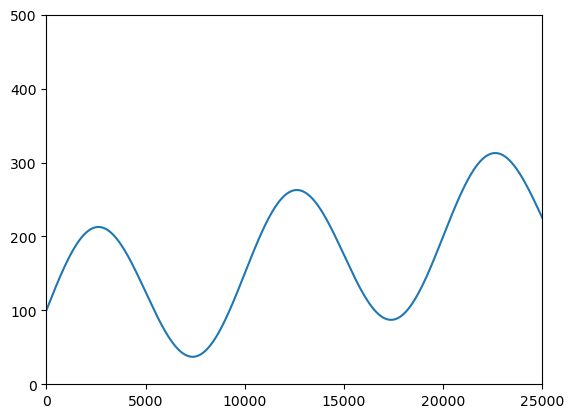

In [3]:
sr = 1e4
t = torch.arange(0, 2.5, 1/sr)
f = torch.sin(2*pi*t) * 1e2 + 1e2 * torch.ones_like(t) + 5e1 * t
x = (torch.sin(torch.cumsum(f, dim=0) / 2e2) + 0.1 *torch.randn(t.shape))[None, :]
x += torch.sin(torch.cumsum(1e2*5 * torch.ones_like(t), dim=0) / 2e2)
x = x.to(device)
print(x.shape)
plt.plot(f)
plt.ylim(top=500, bottom=0)
plt.xlim(left=0, right=25_000);

#specs = {} 
#stfts = {}
#wins = {}
#losses = {} 
#f_hats = {} 
#ss = {} 
#losses2 = {} 
#f_hats2 = {} 
#
#with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
#with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
#with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
#with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)
#with open("../fig/1_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)
#with open("../fig/1_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
#with open("../fig/1_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)
#with open("../fig/1_f_hats2.pkl", "wb") as file: pickle.dump(f_hats2, file, pickle.HIGHEST_PROTOCOL)

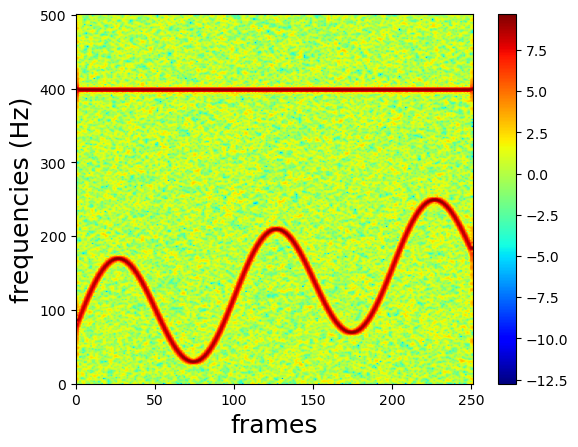

In [3]:
spec = torchaudio.transforms.Spectrogram(n_fft=1_000, win_length=500, hop_length=100)(x.cpu())
ax = plt.subplot()
im = ax.imshow(spec[0].log().cpu(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
plt.colorbar(im, ax=ax)
plt.ylabel('frequencies (Hz)', fontsize=18)
plt.xlabel('frames', fontsize=18);

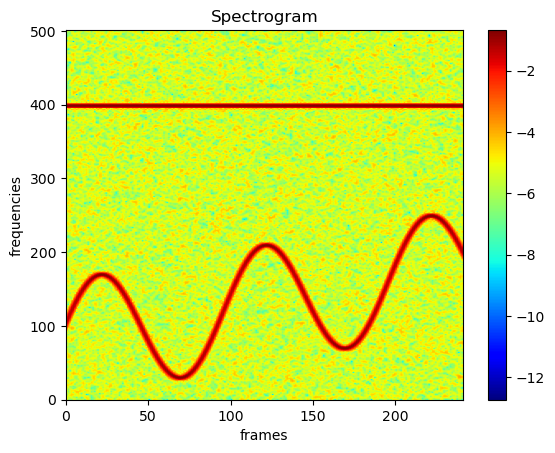

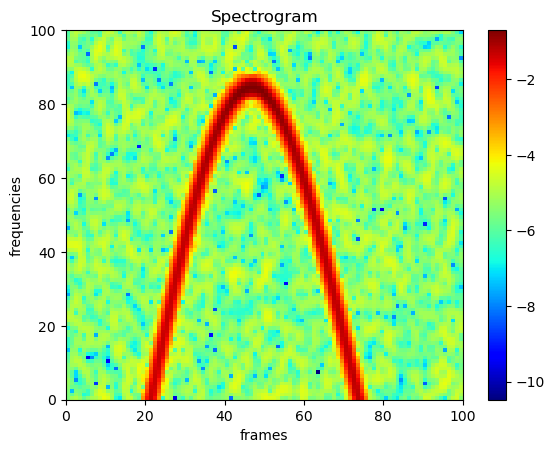

In [4]:
dstft = FDSTFT(x, win_length=500, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, *_ = dstft(x)
#specs['500'] = spec; stfts['500'] = stft; losses['500'] = entropy_loss(spec).cpu(); wins['500'] = dstft.actual_win_length.mean().detach().cpu()
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False) 

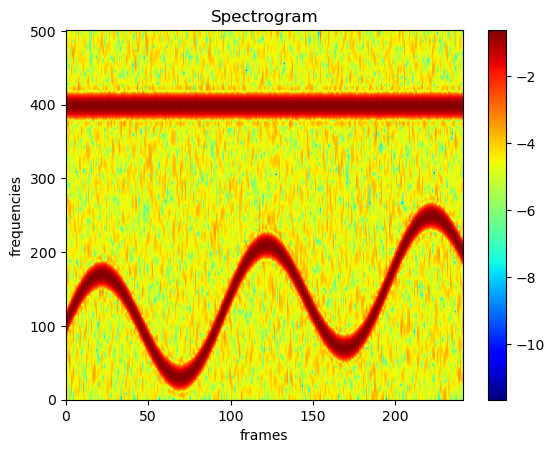

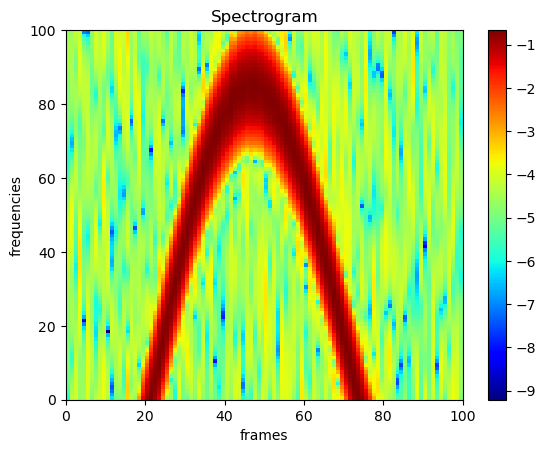

In [5]:
dstft = FDSTFT(x, win_length=100, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)


with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['100'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['100'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['100'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['100'] = entropy_loss(spec).cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

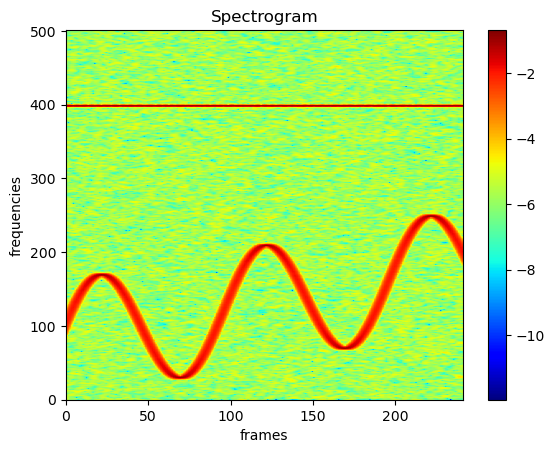

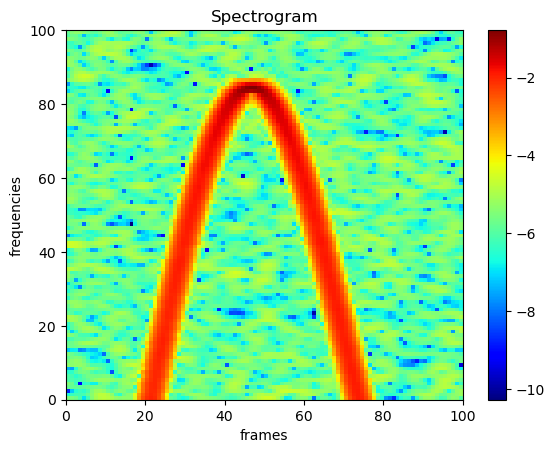

In [6]:
dstft = FDSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['1000'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['1000'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['1000'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['1000'] = entropy_loss(spec).cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Single window length

Epoch 00107: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00207: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00307: reducing learning rate of group 0 to 1.0000e-01.
306 498.4


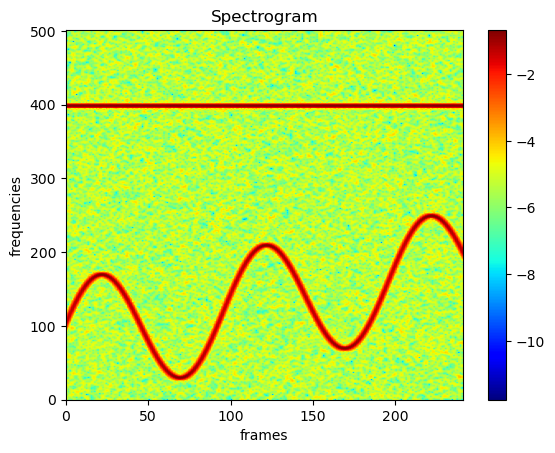

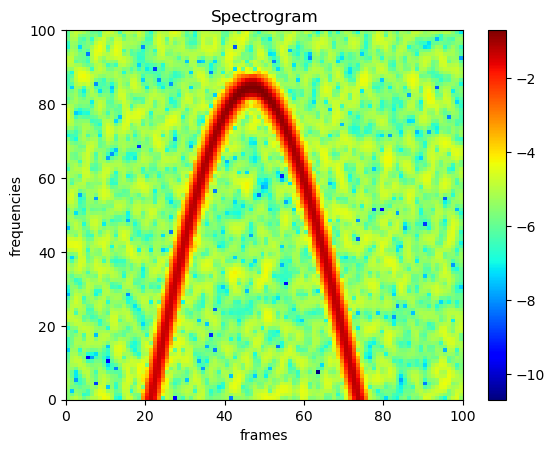

In [7]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch, f'{dstft.win_length.item():.1f}')
dstft.print(spec, x, bar=True, wins=False, weights=False)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['single'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['single'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['single'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['single'] = entropy_loss(spec).detach().cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

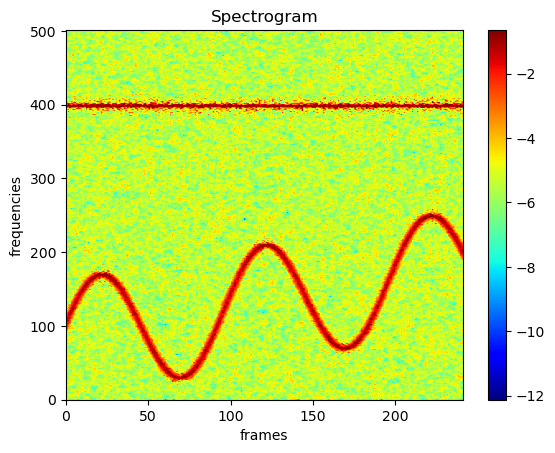

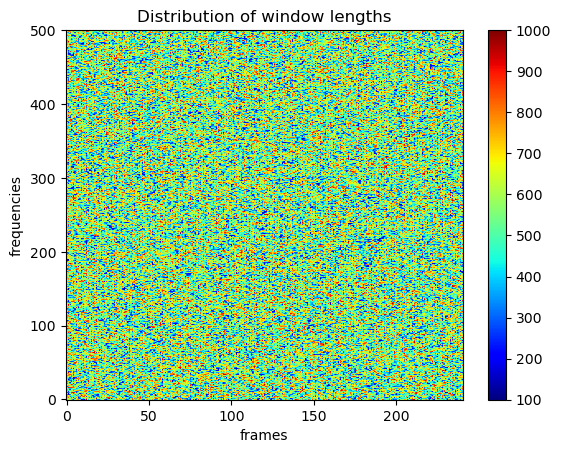

In [8]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
dstft.win_length.data = dstft.win_min + (dstft.win_max - dstft.win_min) * torch.rand(dstft.win_length.size(), device=device)
spec, stft, *_ = dstft(x)
dstft.print(spec, wins=False, bar=True)

with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['random'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['random'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['random'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['random'] = entropy_loss(spec).detach().cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Time-varying window length

Epoch 00137: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00237: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00337: reducing learning rate of group 0 to 1.0000e-01.
336


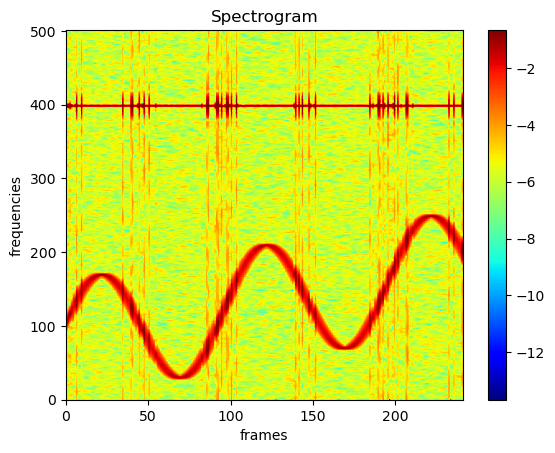

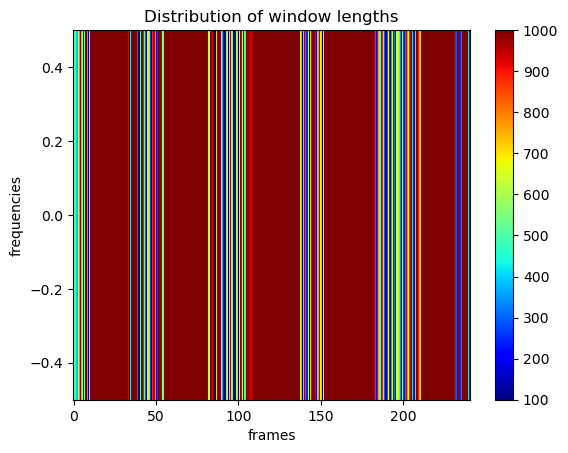

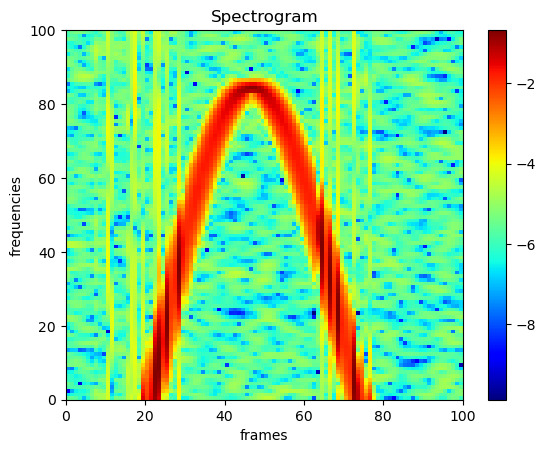

In [9]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['t'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['t'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['t'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['t'] = entropy_loss(spec).detach().cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Epoch 00011: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00021: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00031: reducing learning rate of group 0 to 1.0000e-01.
30


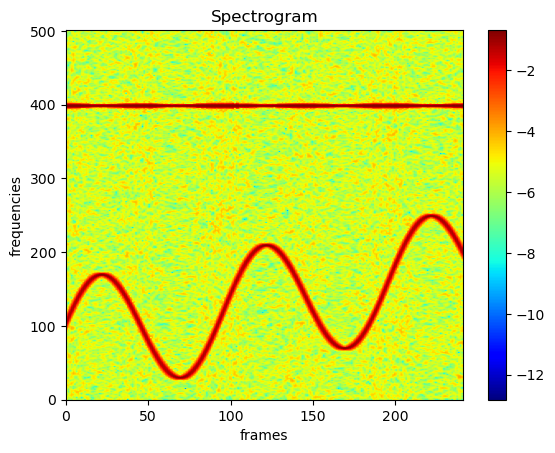

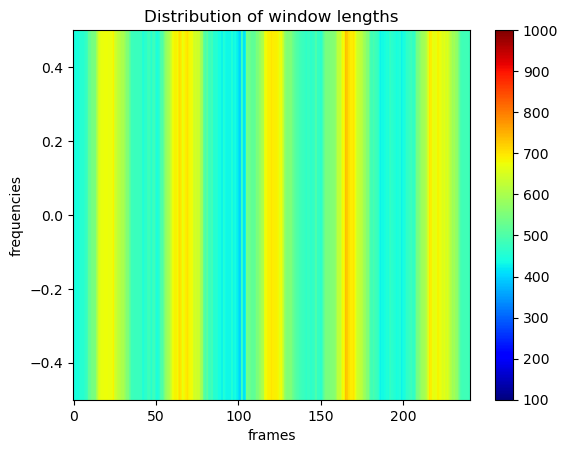

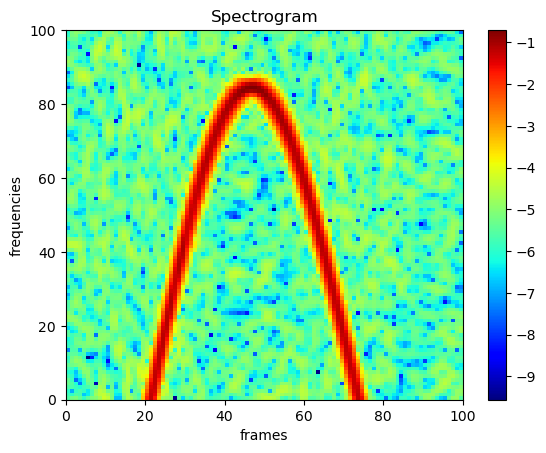

In [10]:
dstft = FDSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['t2'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['t2'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['t2'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['t2'] = entropy_loss(spec).detach().cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

Frequency-varying window length

In [4]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['f'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['f'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['f'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['f'] = entropy_loss(spec).detach().cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['f2'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['f2'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['f2'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['f2'] = entropy_loss(spec).detach().cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

Time-and-frequency-varying window length

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['tf'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['tf'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['tf'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['tf'] = entropy_loss(spec).detach().cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=100, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 125:225, 75:175], x, bar=True, wins=False, weights=False)

with open("../fig/1_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['tf2'] = spec.detach().cpu()
with open("../fig/1_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['tf2'] = stft.detach().cpu()
with open("../fig/1_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['tf2'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/1_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/1_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['tf2'] = entropy_loss(spec).detach().cpu()
with open("../fig/1_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

torch.cuda.empty_cache()

In [ ]:
aaa

498
100
1000
single
random
t
t2


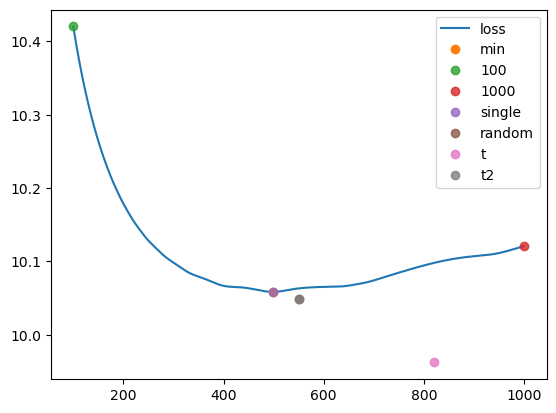

In [11]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, 1000, 1):
    dstft = FDSTFT(x, win_length=win_length, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, 1000, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

for key, loss in losses.items():
    print(key)
    plt.plot(wins[key], loss, 'o', alpha=.8, label=key)
plt.legend()
plt.show()

100 torch.Size([250, 241])


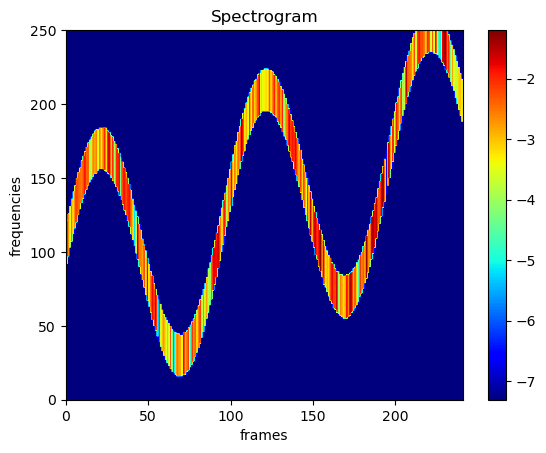

1000 torch.Size([250, 241])


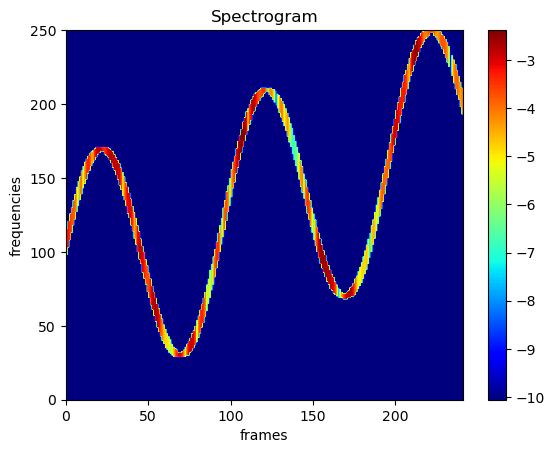

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

In [30]:
with open("../fig/1_stfts.pkl", "rb") as file: stfts = pickle.load(file)
with open("../fig/1_ss.pkl", "rb") as file: ss = pickle.load(file)

for key, stft in stfts.items():
    z = fast_sst(stft[0], 10, stft.shape[-2], stft.shape[-1], .2, device)
    print(key, z.shape)
    dstft.print(z[None, ...], x, bar=True, wins=False, weights=False)
    ss[key] = z
    